# PINN: Harmonic oscillator

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.functional import relu

## neural net

In [10]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(1, 20) # layers of neural net
        self.l2=nn.Linear(20, 20)
        self.l3=nn.Linear(20, 20)
        self.l4=nn.Linear(20, 20)
        self.l5=nn.Linear(20, 1)
        
    def forward(self, x):
        out=torch.tanh(self.l1(x)) # does not work wth only relu, tanh better than sigmoid
        out=torch.tanh(self.l2(out))
        out=torch.tanh(self.l3(out))
        out=torch.tanh(self.l4(out))
        out=self.l5(out)
        return out
    

k=1
m=1

def f(net,t): # differential equation loss
    u=net(t)
    #v = torch.autograd.grad(u, t, create_graph=True,grad_outputs=torch.ones_like(u))[0] is the same
    v = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    a = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    
    mse1=nn.MSELoss()
    pt02 = Variable(torch.zeros((100,1)).float(), requires_grad=False).to(device)
    return mse1(k*u+m*a,pt02)

def u_err(net,t0,u0): # initial condition loss (position u0 at time t0)
    u=net(t0)
    mse1=nn.MSELoss()
    return mse1(u,u0)

def u_err_v(net,t0,v0): # initial condition loss (velocity v0 at time t0)
    u=net(t0)
    v0net=torch.autograd.grad(u.sum(), t0, create_graph=True)[0]
    mse1=nn.MSELoss()
    return mse1(v0net,v0)

def u_err_energy(net,t0,tc): #energy loss (starting time t0, collocation times tc)
    u=net(tc)
    u0=net(t0)
    v0net=torch.autograd.grad(u0.sum(), t0, create_graph=True)[0]
    E0=1/2*m*v0net*v0net+1/2*k*u0*u0
    vnet=torch.autograd.grad(u.sum(), tt, create_graph=True)[0]
    e=1/2*m*vnet*vnet+1/2*k*u*u
    mse1=nn.MSELoss()
    #ptE0 = Variable(torch.ones_like(e).float()*E0, requires_grad=False).to(device)
    return mse1(e,E0)

Using cpu device


## train model

In [12]:

model = NeuralNetwork().to(device)
optimizer=torch.optim.Adam(model.parameters())
for i in range(20000):
    optimizer.zero_grad()
    
    pt_t_bc = Variable(torch.tensor([[0.0]]).float(), requires_grad=True).to(device) # t boundary condition
    pt_u_bc = Variable(torch.tensor([[0.0]]).float(), requires_grad=False).to(device) # position at t_bc
    pt_v_bc = Variable(torch.tensor([[1.0]]).float(), requires_grad=False).to(device) # velocity at t_bc
    
    loss1=u_err(model,pt_t_bc,pt_u_bc)+u_err_v(model,pt_t_bc,pt_v_bc) #initial condition loss

    t=np.random.rand(100,1)*10.0#*min((3+7.0/10000.0*i),10.0) #collocation points
    pt_t= Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    
    loss2=f(model,pt_t)+u_err_energy(model, pt_t_bc, pt_t) #physics loss
    
    loss = loss1+loss2

    # Backpropagation
    loss.backward()
    optimizer.step()

print(f'loss={loss}')

loss=4.798000736627728e-05


## plot results

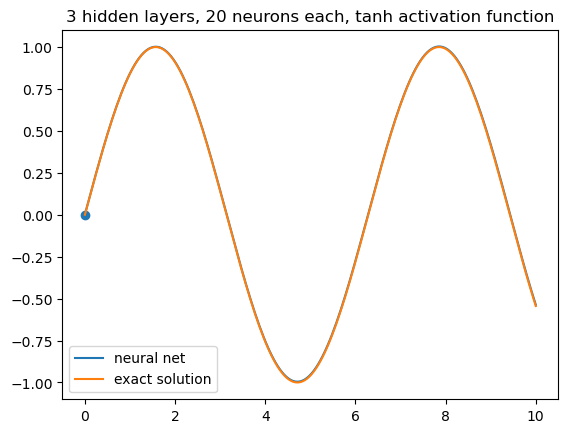

In [17]:
t_test=np.linspace(0,10,200).reshape(200,1)
pt_t_test = torch.from_numpy(t_test).float()  #time interval for test
u_test=model(pt_t_test) #solve DGL with PINN
plt.plot(t_test,u_test.detach().numpy()) #plot PINN output
plt.plot(t_test, np.sin(pt_t_test.numpy())) #plot true solution
plt.scatter(0,0)
plt.title('3 hidden layers, 20 neurons each, tanh activation function')
plt.legend(['neural net','exact solution'])